In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

In [16]:
# データをダウンロード
mnist = input_data.read_data_sets('MNIST')

Extracting MNIST/train-images-idx3-ubyte.gz
Extracting MNIST/train-labels-idx1-ubyte.gz
Extracting MNIST/t10k-images-idx3-ubyte.gz
Extracting MNIST/t10k-labels-idx1-ubyte.gz


In [18]:
# パラメータ設定
input_dim = 784
hidden_encoder_dim = 100
hidden_decoder_dim = 100
latent_dim = 5

In [19]:
# 変数を生成する関数を定義
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.001)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0., shape=shape)
    return tf.Variable(initial)

In [20]:
# 入力を入れるplaceholder
x = tf.placeholder("float", shape=[None, input_dim])

# encoderの重みとバイアスを定義
W1 = weight_variable([input_dim,hidden_encoder_dim])
b1 = bias_variable([hidden_encoder_dim])
W2_mu = weight_variable([hidden_encoder_dim,latent_dim])
b2_mu = bias_variable([latent_dim])
W2_logvar = weight_variable([hidden_encoder_dim,latent_dim])
b2_logvar = bias_variable([latent_dim])

# 平均値を計算すうｒ関数を定義
hidden_encoder = tf.nn.relu(tf.matmul(x, W1) + b1)
mu_encoder = tf.matmul(hidden_encoder, W2_mu) + b2_mu

# 分散を計算する関数を定義
logvar_encoder = tf.matmul(hidden_encoder, W2_logvar) + b2_logvar

# zをサンプリング
epsilon = tf.random_normal(tf.shape(logvar_encoder), name='epsilon')
std_encoder = tf.exp(0.5 * logvar_encoder)
z = mu_encoder + tf.multiply(std_encoder, epsilon)

# decoderの重みとバイアスを定義
W3 = weight_variable([latent_dim,hidden_decoder_dim])
b3 = bias_variable([hidden_decoder_dim])
W4 = weight_variable([hidden_decoder_dim, input_dim])
b4 = bias_variable([input_dim])

# xを生成する関数を定義
hidden_decoder = tf.nn.relu(tf.matmul(z, W3) + b3)
x_hat = tf.matmul(hidden_decoder, W4) + b4

# ロス関数を定義
KLD = -0.5 * tf.reduce_sum(1 + logvar_encoder - tf.pow(mu_encoder, 2) - tf.exp(logvar_encoder), reduction_indices=1)
BCE = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=x_hat, labels=x), reduction_indices=1)
loss = tf.reduce_mean(BCE + KLD)

# lossを最小化する手法を設定
train_step = tf.train.AdamOptimizer(0.01).minimize(loss)

In [21]:
# 学習
saver = tf.train.Saver()
n_steps = 5000
batch_size = 100

with tf.Session() as sess:
    print("初期化")
    sess.run(tf.global_variables_initializer())

    for step in range(1, n_steps):
        batch = mnist.train.next_batch(batch_size)
        feed_dict = {x: batch[0]}
        _, cur_loss = sess.run([train_step, loss], feed_dict=feed_dict)

        if step % 50 == 0:
            # モデルを保存
            saver.save(sess, "model.ckpt")
            print("Step {0} | Loss: {1}".format(step, cur_loss))

初期化
Step 50 | Loss: 203.64865112304688
Step 100 | Loss: 190.54820251464844
Step 150 | Loss: 163.44662475585938
Step 200 | Loss: 172.041015625
Step 250 | Loss: 172.14996337890625
Step 300 | Loss: 152.79173278808594
Step 350 | Loss: 153.13583374023438
Step 400 | Loss: 149.41575622558594
Step 450 | Loss: 146.14276123046875
Step 500 | Loss: 143.9248046875
Step 550 | Loss: 137.74510192871094
Step 600 | Loss: 134.4955596923828
Step 650 | Loss: 139.21145629882812
Step 700 | Loss: 139.8284149169922
Step 750 | Loss: 138.5565643310547
Step 800 | Loss: 132.3440704345703
Step 850 | Loss: 140.44529724121094
Step 900 | Loss: 138.3330535888672
Step 950 | Loss: 137.05865478515625
Step 1000 | Loss: 131.3252716064453
Step 1050 | Loss: 145.70289611816406
Step 1100 | Loss: 138.15560913085938
Step 1150 | Loss: 142.2063446044922
Step 1200 | Loss: 141.07803344726562
Step 1250 | Loss: 127.98339080810547
Step 1300 | Loss: 138.9432830810547
Step 1350 | Loss: 133.95921325683594
Step 1400 | Loss: 136.862213134765

INFO:tensorflow:Restoring parameters from model.ckpt
[[ 0 -1 -1  1  0]]


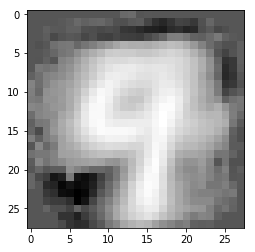

[[ 0  0  0 -1 -1]]


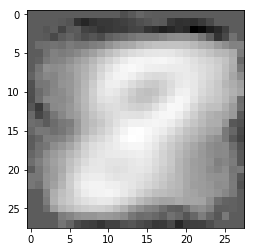

[[1 0 0 0 0]]


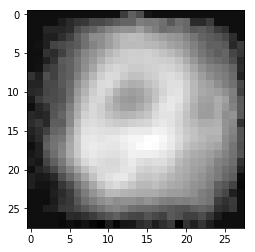

[[-1 -1  1  1 -1]]


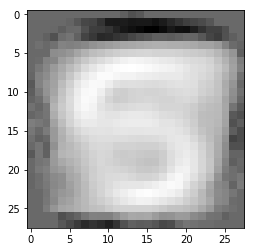

[[-1  0  0 -1  0]]


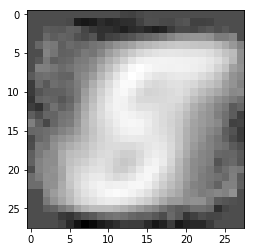

[[1 0 1 1 1]]


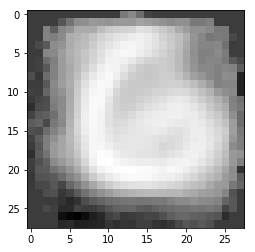

[[ 1  0  1  1 -1]]


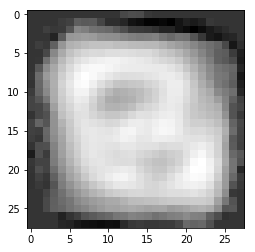

[[-1  1 -1 -1  1]]


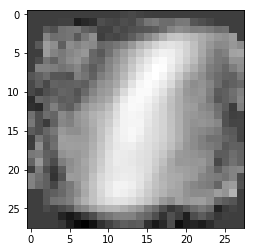

[[ 1  0 -1  1  0]]


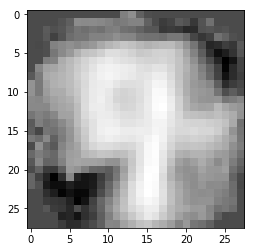

[[ 0  0  1  0 -1]]


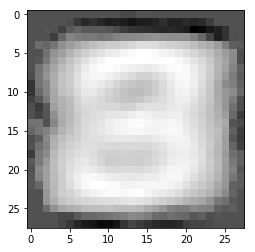

In [22]:
# 生成
# 隠れ変数を入れるplaceholder
z_gen = tf.placeholder("float", shape=[1,latent_dim])

# 画像を生成する関数を定義
hidden_decoder = tf.nn.relu(tf.matmul(z_gen, W3) + b3)
x_gen = tf.matmul(hidden_decoder, W4) + b4

saver = tf.train.Saver()

with tf.Session() as sess:
    # モデル読み込み
    saver.restore(sess, "model.ckpt")
    
    for i in range(10):
        # 隠れ変数をランダムに生成
        z = np.random.randint(-1,2, (1,latent_dim))

        feed_dict = {z_gen: z}
        x = sess.run([x_gen], feed_dict=feed_dict)

        print( z )
        plt.imshow( x[0].reshape( 28,28 ) , cmap="gray"  )
        plt.show()